# Fit exponentials to Cell 5 from Kylie

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

To do:
- Code an exponential approximation <- DONE
- load data
- minimize residuals



In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [2]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

## A meta parameter

All the jump voltages have a time at the beggining that we will remove. We'll remove 50ms 
times_to_skip = 50 

In [3]:
times_to_skip = 50 

## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

## Separate by V level

The current and time is partitinonated to a level of V

In [4]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')


# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i]+times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))


42


## Define color scheme by V's

There are 9 unique V's. (-120, -80:20:60), So I need 9 unique colors. 

In [22]:
# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])
print(pr3_unique_Vs_index)
print(pr3_unique_Vs_1stUindex)
print(pr3_voltage_constV_labels_simple)
print(pr3_voltage_constV_labels_full)

[1 0 1 2 3 0 1 0 1 3 0 1 0 1 4 3 0 1 0 1 5 3 0 1 0 1 6 3 0 1 0 1 7 3 0 1 0
 1 8 3 0 1]
[ 1  0  3  4 14 20 26 32 38]
['V =-80.0' 'V =-120.0' '_nolegend_' 'V =-60.0' 'V =-40.0' '_nolegend_'
 '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_'
 '_nolegend_' '_nolegend_' '_nolegend_' 'V =-20.0' '_nolegend_'
 '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_' 'V =0.0' '_nolegend_'
 '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_' 'V =20.0'
 '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_'
 'V =40.0' '_nolegend_' '_nolegend_' '_nolegend_' '_nolegend_'
 '_nolegend_' 'V =60.0' '_nolegend_' '_nolegend_' '_nolegend_']
['V =-80.0', 'V =-120.0', 'V =-80.0', 'V =-60.0', 'V =-40.0', 'V =-120.0', 'V =-80.0', 'V =-120.0', 'V =-80.0', 'V =-40.0', 'V =-120.0', 'V =-80.0', 'V =-120.0', 'V =-80.0', 'V =-20.0', 'V =-40.0', 'V =-120.0', 'V =-80.0', 'V =-120.0', 'V =-80.0', 'V =0.0', 'V =-40.0', 'V =-120.0', 'V =-80.0', 'V =-120.0', 'V =-80.0', 'V =20.0', 'V =-40.0', 'V =-120

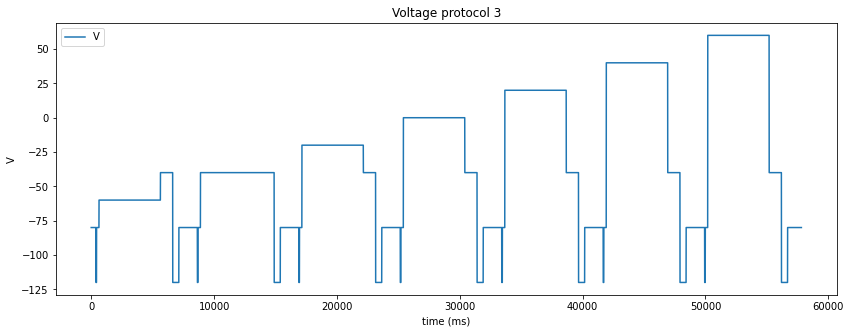

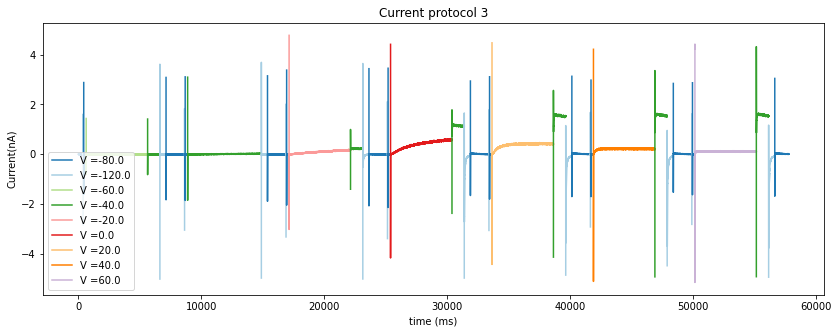

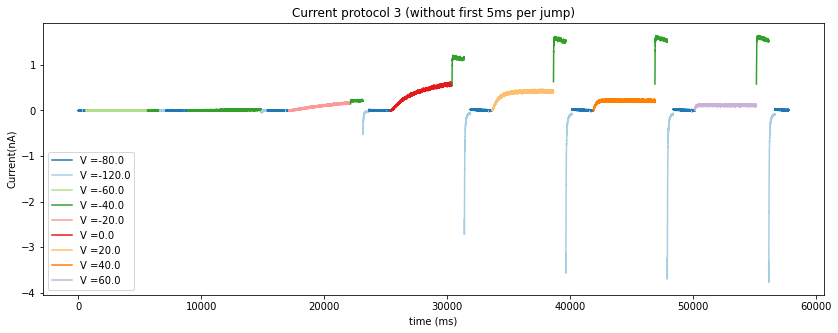

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(pr3_time, pr3_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()



## Estimate epsilon from V = -80

- load data for V=-80
- take residuals ? 
    - does it makes sense or is it directly take values since the mean current is zero?
- Get R^2 by batch and mean
- Get the mean of the R^2

15


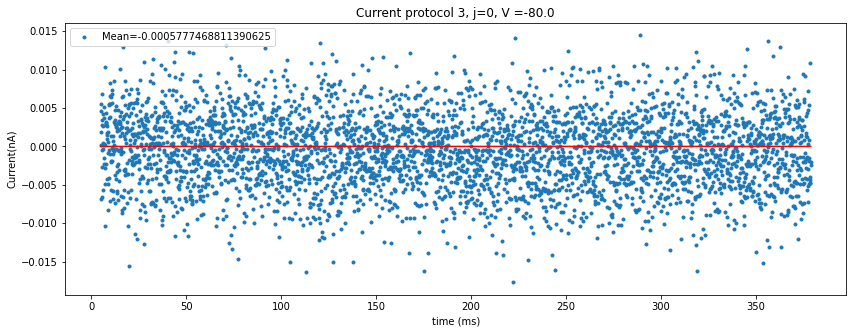

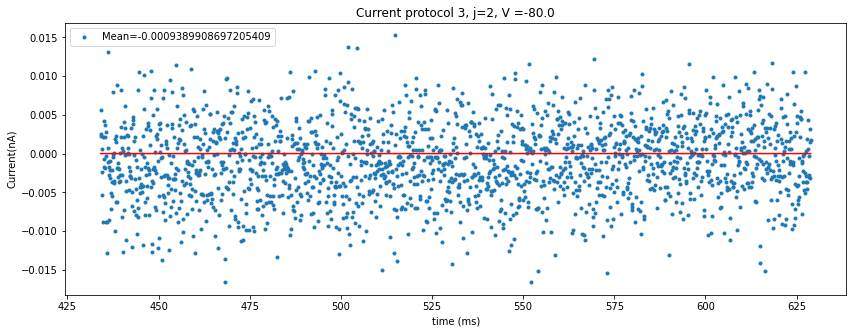

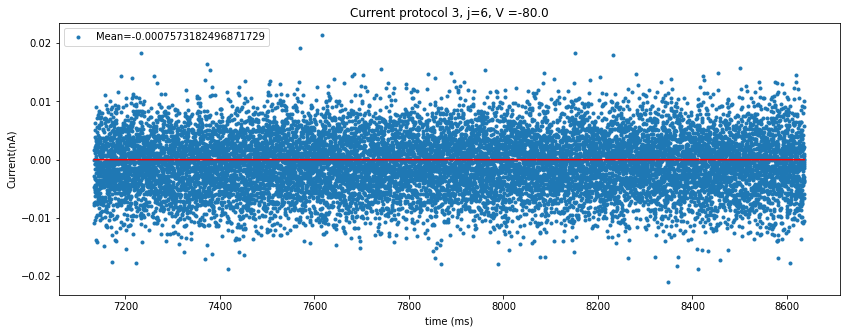

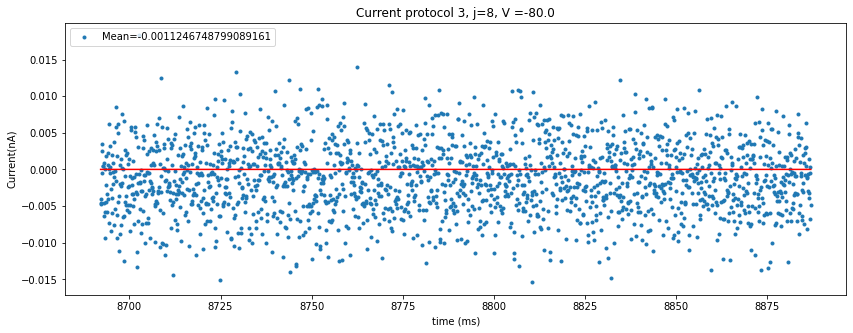

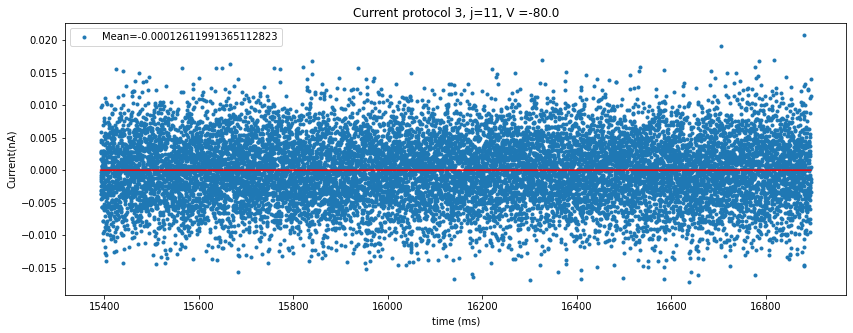

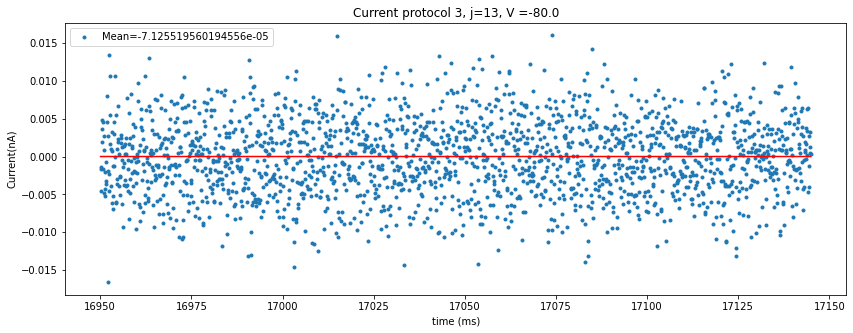

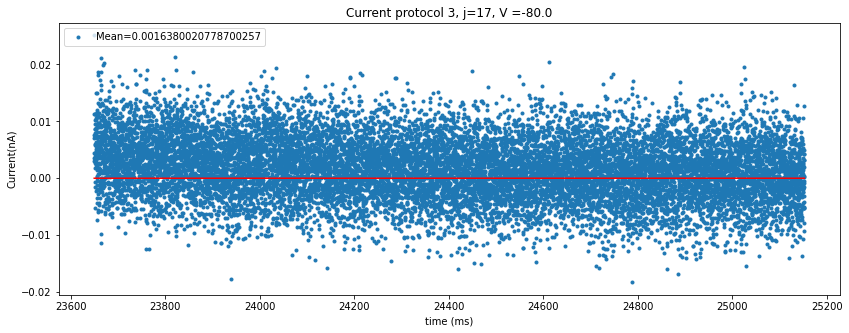

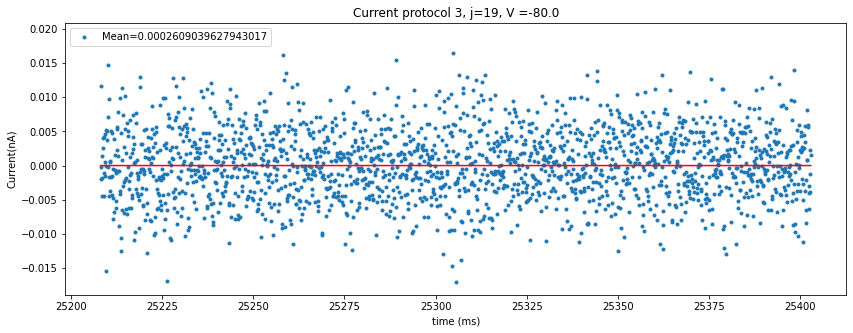

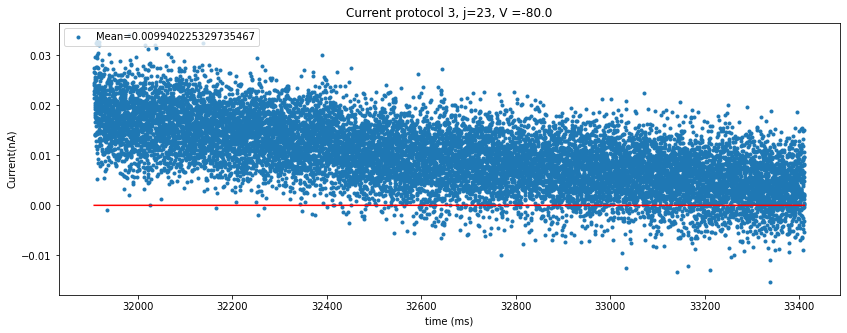

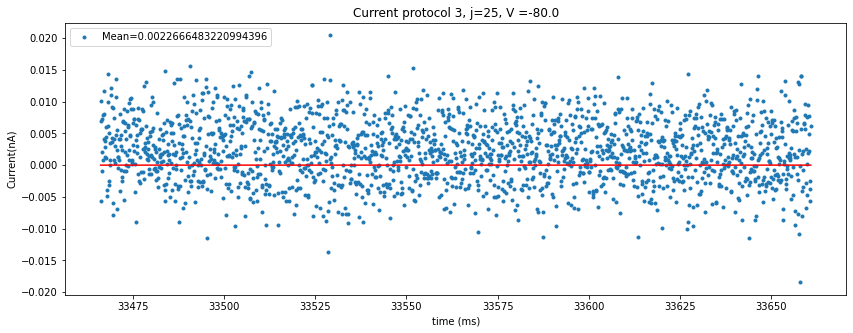

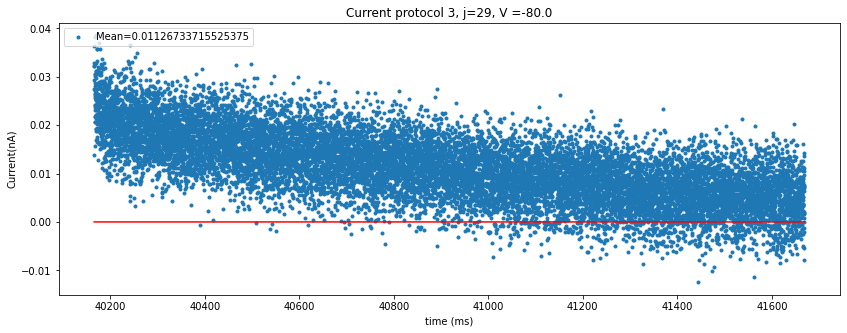

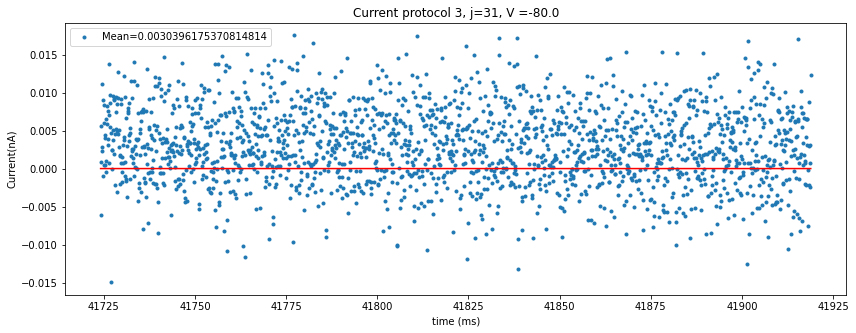

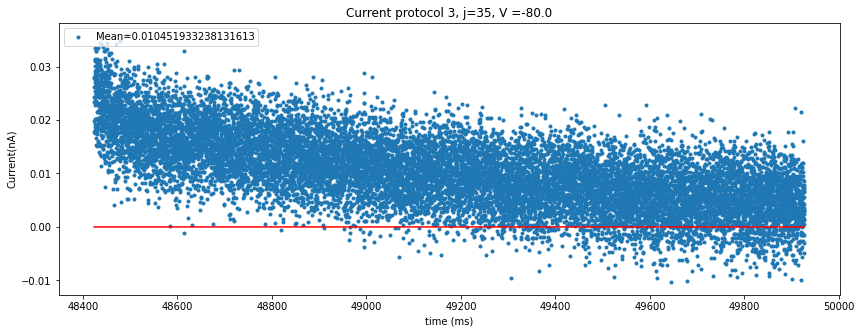

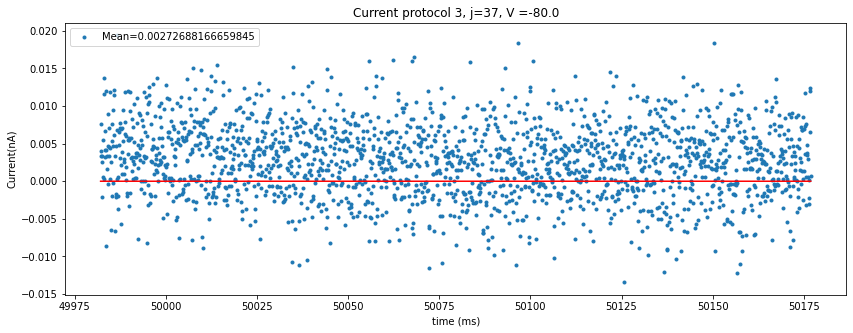

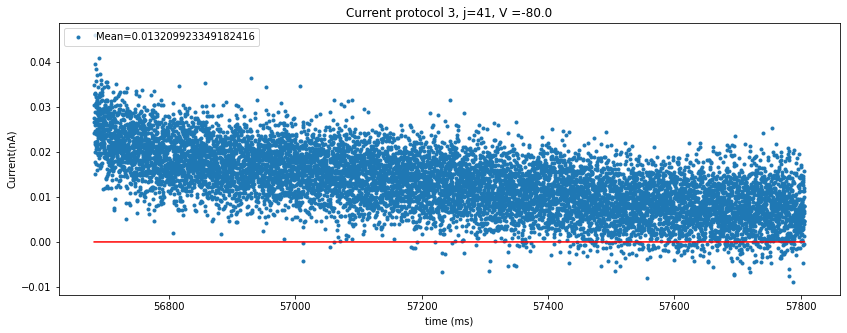

In [23]:
# Find where V = -80
print(sum(pr3_voltage_constV==-80))
index_neg80 = np.nonzero(pr3_voltage_constV==-80)
index_neg80 = index_neg80[0]
index_neg80_meanzero = []
V80_means = np.zeros(len(index_neg80))
V80_vars = np.zeros(len(index_neg80))


#pr3_current_constV_all80s =np.array([])
pr3_current_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_means[k] = np.mean(pr3_current_constV_without_first5ms[j])
    V80_vars[k] = np.var(pr3_current_constV_without_first5ms[j])
    #pr3_current_constV_all80s = np.append(pr3_current_constV_all80s, pr3_current_constV[j][times_to_skip:])
    if np.abs(V80_means[k]) < 0.009:
        index_neg80_meanzero.append(j)
        pr3_current_constV_80smeanzero =np.append(pr3_current_constV_80smeanzero, pr3_current_constV_without_first5ms[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j],'.', color = pr3_voltage_constV_colors[j], label='Mean='+str(np.mean(pr3_current_constV_without_first5ms[j])))
    plt.plot(pr3_time_constV_without_first5ms[j],np.zeros(len(pr3_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr3_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


In [24]:
print(index_neg80_meanzero)
#print(V80_vars)
print('---- ALL V=-80 -------- V=-80 AND |mean|<0.009---')
print('Mean of means by jump:')
print([np.mean(V80_means), np.mean(V80_means[np.abs(V80_means)<0.009])])
print('Mean of all the time steps together:')
print([0, np.mean(pr3_current_constV_80smeanzero)])


print('Mean of Vars per jump:')
#print(V80_vars[np.abs(V80_means)<0.009])
epsilonA = np.mean(V80_vars)
epsilonB = np.mean(V80_vars[np.abs(V80_means)<0.009])
print([epsilonA, epsilonB])


print('Var of all the time steps together:')
epsilon1 = np.var(pr3_current_constV_80smeanzero)
print([0, epsilon1])



[0, 2, 6, 8, 11, 13, 17, 19, 25, 31, 37]
---- ALL V=-80 -------- V=-80 AND |mean|<0.009---
Mean of means by jump:
[0.0034136911099358785, 0.0005759952342486302]
Mean of all the time steps together:
[0, 0.0003391021796864299]
Mean of Vars per jump:
[3.0527468270471126e-05, 2.4792563496821662e-05]
Var of all the time steps together:
[0, 2.702548900276314e-05]


# Leak current

I'll check the transition between V=-80 to V=-120 to check if the leak current has been removed from the data set. 

For protocol 3, we always have the sequence of Vs: 40, -120, -80, -120, -80. And I'm interested in the -80,-120, -80 part. 

[ 0  2  6  8 11 13 17 19 23 25 29 31 35 37]
[ 0  6 11 17 23 29 35]


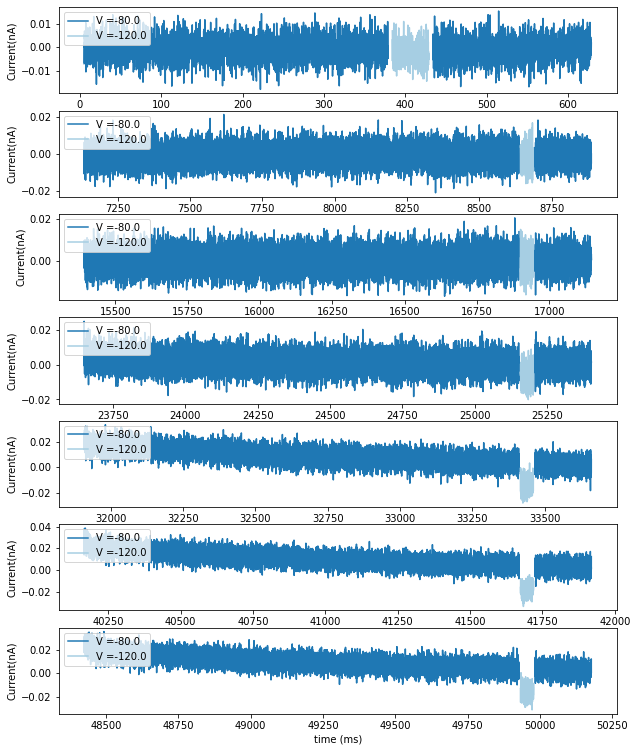

In [29]:

index_leak80 = np.nonzero(pr3_voltage_constV[:-2]==-80)
index_leak80 = index_leak80[0]
index_leak120 = np.nonzero(pr3_voltage_constV[index_leak80+1]==-120)
index_leak120 = index_leak120[0]
print(index_leak80)
print(index_leak80[index_leak120])

index_leak = index_leak80[index_leak120] # Index for the -80 to start the -80,-120,-80 jump. 


fig, axs = plt.subplots(len(index_leak),1, figsize=(10, 13))
axs = axs.ravel()

for k in range(len(index_leak)):
    j = index_leak[k]
    
    axs[k].plot(pr3_time_constV_without_first5ms[j], pr3_current_constV_without_first5ms[j], color = pr3_voltage_constV_colors[j], label=pr3_voltage_constV_labels_full[j])
    axs[k].plot(pr3_time_constV_without_first5ms[j+1], pr3_current_constV_without_first5ms[j+1], color = pr3_voltage_constV_colors[j+1], label=pr3_voltage_constV_labels_full[j+1])
    axs[k].plot(pr3_time_constV_without_first5ms[j+2], pr3_current_constV_without_first5ms[j+2], color = pr3_voltage_constV_colors[j+2], label='_nolegend_')
    axs[k].set_ylabel('Current(nA)')
    axs[k].legend(loc='upper left')
axs[k].set_xlabel('time (ms)')

plt.show()

## Voltage larger or equal than -40


In [34]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

splines_largerCurrents = [None] * len(index_largerCurrents)
splines_params_largerCurrents = [None] * len(index_largerCurrents)
residuals2_largerCurrents = [None] * len(index_largerCurrents)
times_largerCurrents = [None] * len(index_largerCurrents)
currents_largerCurrents = [None] * len(index_largerCurrents)
deltat_largerCurrents = np.zeros(len(index_largerCurrents))

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    currents_largerCurrents[index_i] = pr3_current_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]


[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


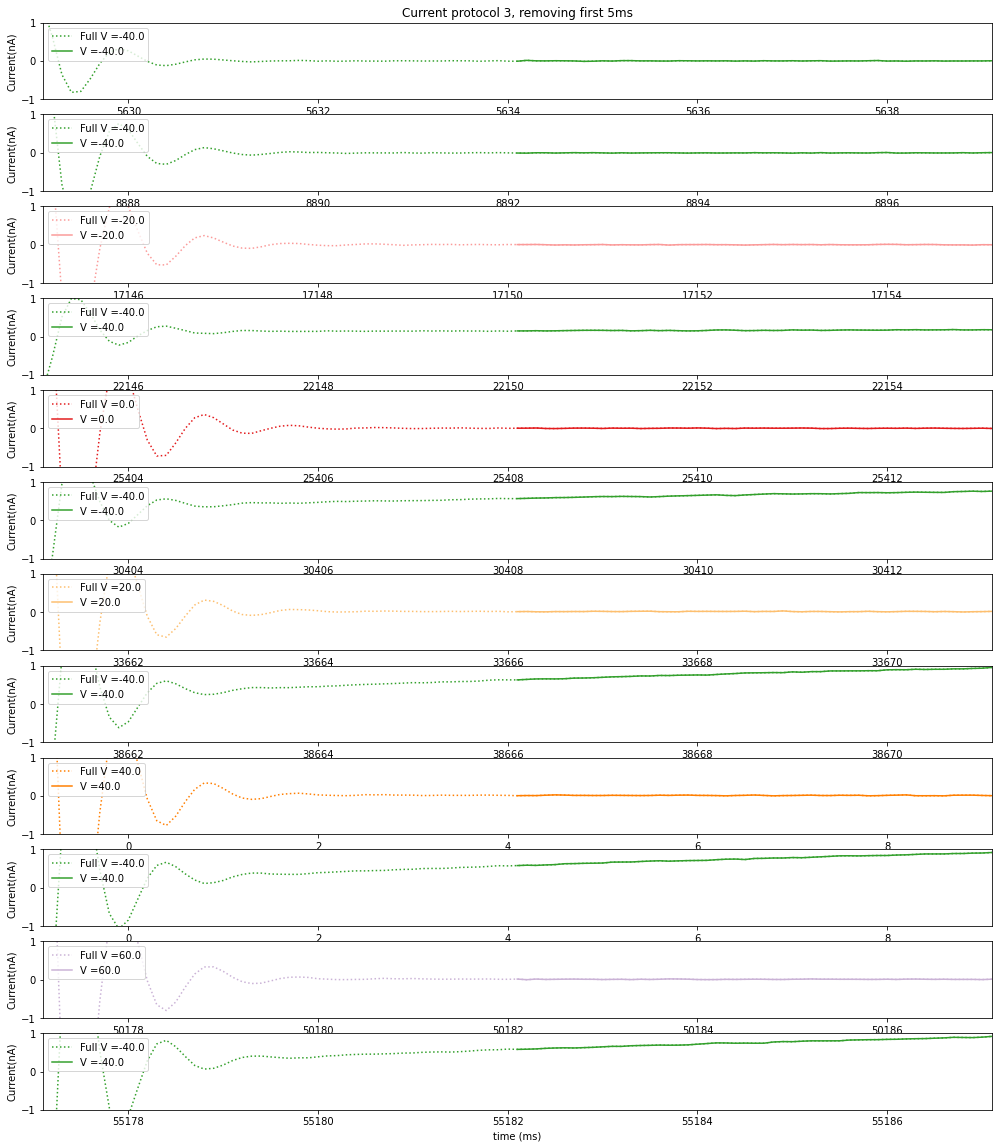

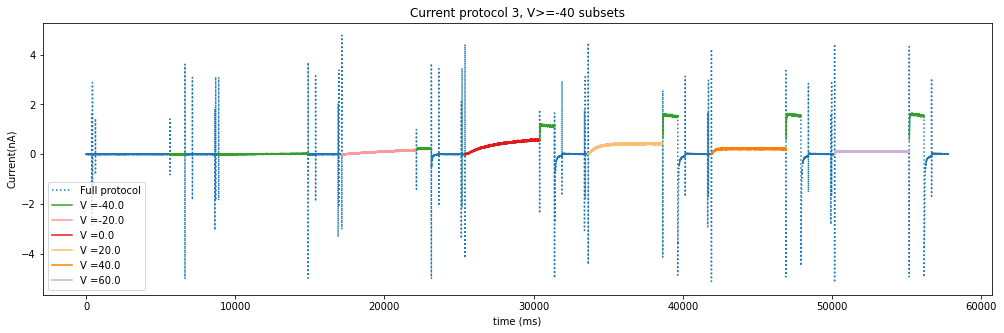

In [55]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()


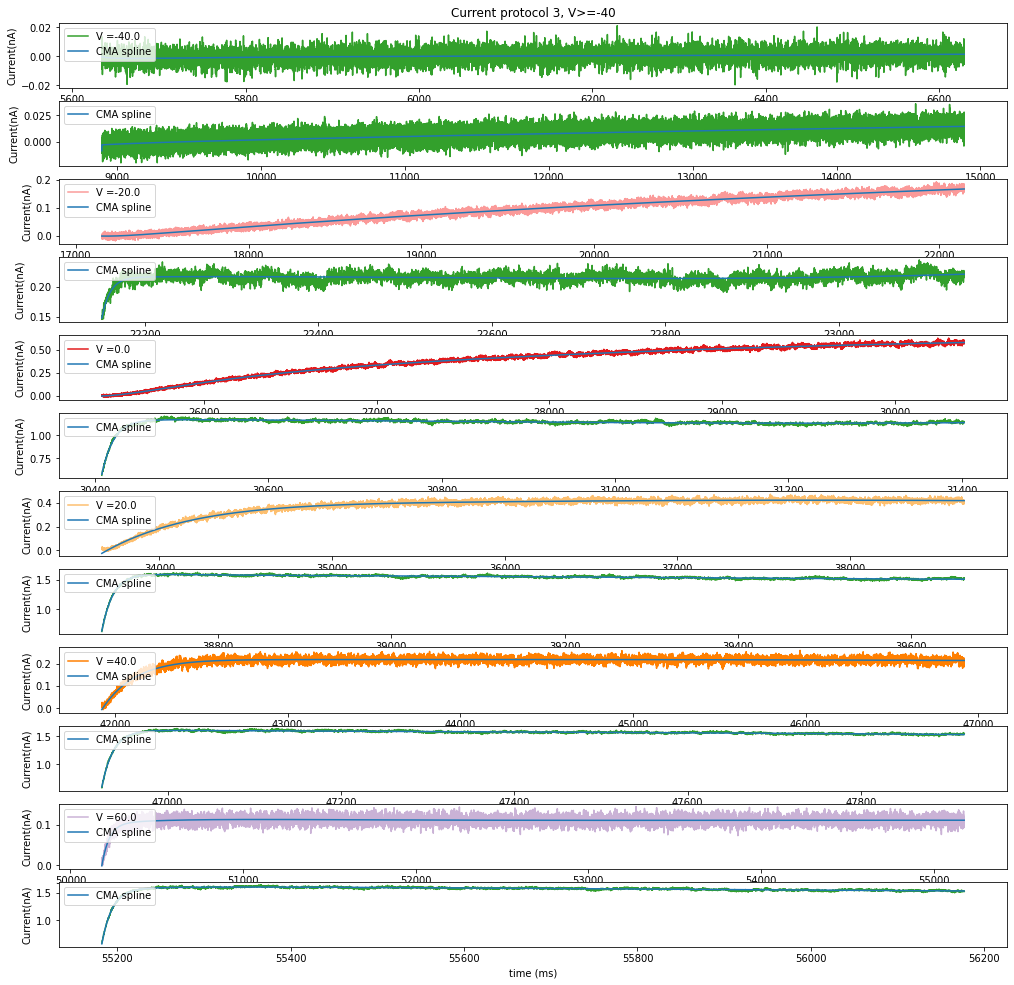

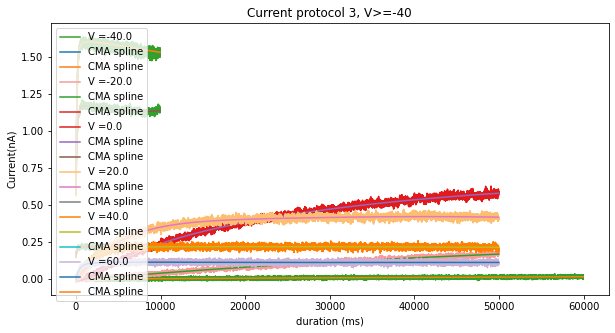

In [60]:
# CMA fit
NumExpo_flag = True

for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    #Inital conditions and constrains:
    if NumExpo_flag:
        p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
        bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
    else:
        p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
        bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

    optscma = cma.CMAOptions()
    optscma.set("bounds", bounds_cma)
    # CMA fit
    es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
    splines_params_largerCurrents[index_i] = es[0]
    splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)


# Trying a better plot
fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 17))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Trying a better plot
fig, axs = plt.subplots(5,1, figsize=(10, 13))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# CMA_fit with weighting residuals
 
NumExpo_flag = True

for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    #Inital conditions and constrains:
    if NumExpo_flag:
        p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
        bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
    else:
        p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
        bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

    optscma = cma.CMAOptions()
    optscma.set("bounds", bounds_cma)
    # CMA fit
    es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
    splines_params_largerCurrents[index_i] = es[0]
    splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)

fig, axs = plt.subplots(5,1, figsize=(10, 13))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Zoom

fig, axs = plt.subplots(5,1, figsize=(10, 13))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', ,color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0],times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03,0.07])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()

In [ ]:
# Residuals


plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents[index_i]
    residuals2_largerCurrents[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], residuals2_largerCurrents[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-30')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-30')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Single channel parameters
N=76000
Ek = -85
gamma_i = 2e-6# 2 pS -> to uS

V = pr3_voltage[pr3_Vtimes[i]]
indv_current = (V - Ek)*gamma_i # gamma = i/(V - E)

In [ ]:
# Get residuals
residuals = splines_largerCurrents[index_i] - currents_largerCurrents[index_i]
residuals2_largerCurrents[index_i] = residuals**2

plt.figure(figsize=(14, 5))
plt.scatter(times_largerCurrents[index_i], residuals2_largerCurrents[index_i])
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure()
plt.hist(residuals, bins = 100)
plt.xlabel('Residuals')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure(figsize=(14, 5))
plt.scatter(splines_largerCurrents[index_i], residuals2_largerCurrents[index_i])
plt.plot(splines_largerCurrents[index_i], splines_largerCurrents[index_i] * (indv_current - splines_largerCurrents[index_i]/N),'r')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))
plt.show()

plt.show()

In [ ]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 100

remove_at_end = len(residuals2_largerCurrents[index_i])%batch_size
print(remove_at_end)
residuals2_meanbatch = np.mean(np.reshape(residuals2_largerCurrents[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
cma_expo_fit_meanbatch = np.mean(np.reshape(splines_largerCurrents[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
times_meanbatch = np.mean(np.reshape(times_largerCurrents[index_i][:-remove_at_end],[-1, batch_size]),axis=1)

plt.figure(figsize=(14, 5))
plt.scatter(times_meanbatch, residuals2_meanbatch)
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))

plt.figure()
plt.hist(residuals2_meanbatch, bins = 100)
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'N '+str(N))
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'N = 1000')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'toy epsilon, N '+str(N))
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'toy epsilon, N = 1000')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, epsilon1, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()



## Just to double check: linear regresion:

In [ ]:
x =  cma_expo_fit_meanbatch.reshape(-1,1)
y = residuals2_meanbatch
model_LR = LinearRegression()
model_LR.fit(x, y)
r_sq = model_LR.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)

print('individual current = ', indv_current)

In [ ]:
plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.plot(cma_expo_fit_meanbatch, model_LR.intercept_ + cma_expo_fit_meanbatch * model_LR.coef_, label = 'LR')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()

## Generalize for the other V>-40 voltages

### THE FOLLOWING HAS TO BE RE-EDITED!

In [ ]:
index_i = 1


i=index_largerCurrents[index_i]
times_to_skip = 50
V = pr3_voltage[pr3_Vtimes[i]]
indv_current = (V - Ek)*gamma_i # gamma = i/(V - E)

times_neg30[index_i] = pr3_time[(pr3_Vtimes[i]+times_to_skip):(pr3_Vtimes[i+1]-1)]
currents_neg30[index_i] = pr3_current_constV[i][times_to_skip:]
deltat = times_neg30[index_i][0]
three_flag = True

p0 = [0, 0.01,times_neg30[index_i][-1]-times_neg30[index_i][0], 0.01,-(times_neg30[index_i][-1]-times_neg30[index_i][0]), -0.01, -(times_neg30[index_i][-1]-times_neg30[index_i][0])/2 ]

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))

plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]+times_to_skip):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i][times_to_skip:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))

plt.legend(loc='upper left')
plt.show()


# Let's try with CMA
es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag])
splines_params_neg30[index_i] = es[0]
splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)

plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')


plt.show()


# Get residuals
residuals = splines_neg30[index_i] - currents_neg30[index_i]
residuals2_neg30[index_i] = residuals**2

plt.figure(figsize=(14, 5))
plt.scatter(times_neg30[index_i], residuals2_neg30[index_i])
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure()
plt.hist(residuals, bins = 100)
plt.xlabel('Residuals')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure(figsize=(14, 5))
plt.scatter(splines_neg30[index_i], residuals2_neg30[index_i])
plt.plot(splines_neg30[index_i], splines_neg30[index_i] * (indv_current - splines_neg30[index_i]/N),'r')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))
plt.show()

plt.show()


In [ ]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 100

remove_at_end = len(residuals2_neg30[index_i])%batch_size
print(remove_at_end)
residuals2_meanbatch = np.mean(np.reshape(residuals2_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
cma_expo_fit_meanbatch = np.mean(np.reshape(splines_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)
times_meanbatch = np.mean(np.reshape(times_neg30[index_i][:-remove_at_end],[-1, batch_size]),axis=1)

plt.figure(figsize=(14, 5))
plt.scatter(times_meanbatch, residuals2_meanbatch)
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))

plt.figure()
plt.hist(residuals2_meanbatch, bins = 100)
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]) + ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'N '+str(N))
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'N = 1000')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilon1, N '+str(N))
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/10000), label = 'epsilon1, N = 1000')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, epsilon1, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.figure(figsize=(14, 5))
plt.scatter(cma_expo_fit_meanbatch, residuals2_meanbatch)
plt.plot(cma_expo_fit_meanbatch, cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'No epsilon')
plt.plot(cma_expo_fit_meanbatch, epsilonA + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonA')
plt.plot(cma_expo_fit_meanbatch, epsilonB + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'epsilonB')
plt.plot(cma_expo_fit_meanbatch, epsilon1 + cma_expo_fit_meanbatch * (indv_current - cma_expo_fit_meanbatch/N), label = 'Epsilon1')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]])+ ' batch size = ' + str(batch_size))


plt.show()



## Rest of the protocols

In [ ]:
# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()


## My testing code

In [ ]:
tmax = 20
dt = .1
deltat = 100
times = np.arange(0, tmax+dt, dt)
params = np.array([10,.001,100,.01,-100, .001,300])
epsi = 0.0001*np.random.randn(len(times))

three_flag = True

x =  expo_spline(times, deltat, params, three_flag)+ epsi
y = SRexpo_spline(params, times, deltat, x, three_flag)


res = minimize(SRexpo_spline, params,args = (times,deltat, x, three_flag), method='Nelder-Mead', tol=1e-6)

params_res = res.x
z =  expo_spline(times, deltat, params_res, three_flag)


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,z, label = 'Fit')
plt.legend()
plt.show()

print(params_res)
print(params)


In [ ]:
# testing CMA
p0 = params # [0,1,1,.5,1]
es = cma.fmin(SRexpo_spline, params , sigma0=1, args=[times, deltat, x, three_flag])

params_cma = es[0]
score_cma = es[1]


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,expo_spline(times, deltat, params_cma, three_flag), label = 'Fit')
plt.legend()
plt.show()

print(params_cma)
print(score_cma)

In [ ]:
p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]

three_flag = True
if three_flag:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0, 0, 0], [None, None, None, None, None, None, None]]
else:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0]]#, 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
#es = cma.fmin(NBlike_SIR, x0_SIR, sigma0=1, args=(p, parameters_to_optimise_SIR, data_D, travel_data), options = optsSIR)

es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag], options = optscma)
splines_params_neg30[index_i] = es[0]
splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()

In [ ]:
p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]

three_flag = True
if three_flag:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0], 0.1, times_neg30[index_i][0], 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
else:
    p0 = [splines_neg30[index_i][-1],splines_neg30[index_i][-1] ,times_neg30[index_i][-1] - times_neg30[index_i][0] ,0.01 , times_neg30[index_i][-1] - times_neg30[index_i][0]]#, 0.1, times_neg30[index_i][0] ]
    bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]

#p0 = [0.63, 1.4,1788,0.8, 1086]

p0 = [0.63, 1.48*0.88,1628,0.85*0.83, 1277,0.02*0.33,177,0.1,1]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
#optscma.set('tolfun', 1e-12)

#es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_neg30[index_i], deltat, currents_neg30[index_i],three_flag], options = optscma)
#splines_params_neg30[index_i] = es[0]
#splines_neg30[index_i] = expo_spline(times_neg30[index_i], deltat, splines_params_neg30[index_i], three_flag)



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
#plt.plot(times_neg30[index_i], expo_spline(times_neg30[index_i], deltat, p0, three_flag), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()

In [ ]:
x = np.arange(0, 40, 0.1)
y = np.ones(len(x))
w = 1 / (1 + 9*(x>1) + 90 * (x>10))
print(w)

In [ ]:
index_i = 2
i=index_largerCurrents[index_i]

# Testing definitions
#res = currents_neg30[index_i] - splines_neg30[index_i]
#res2 = res**2
w  = 1 / (1 + 9*((times_neg30[index_i]-deltat_neg30[index_i])>10) + 90*((times_neg30[index_i]-deltat_neg30[index_i])>100) + 900*((times_neg30[index_i]-deltat_neg30[index_i])>1000))



plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], res2,'-', label='R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times_neg30[index_i], w*res2,'.', label='w*R^2 V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('residuals')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')
plt.show()


p0 = [currents_neg30[index_i][-1], 0.01,times_neg30[index_i][-1]-times_neg30[index_i][0], 0.01,(times_neg30[index_i][-1]-times_neg30[index_i][0]), 0.01, (times_neg30[index_i][-1]-times_neg30[index_i][0])/2, 0.1,1]
bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]

optscma = cma.CMAOptions()
optscma.set("bounds", bounds_cma)
    # CMA fit
es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_neg30[index_i], deltat_neg30[index_i], currents_neg30[index_i], NumExpo_flag], options = optscma)
s_neg30_W_test = expo_spline(times_neg30[index_i], deltat_neg30[index_i], es[0], NumExpo_flag)

plt.figure(figsize=(14, 5))
plt.plot(times_neg30[index_i], currents_neg30[index_i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
#plt.plot(times_neg30[index_i], splines_neg30[index_i], label = 'CMA spline')
plt.plot(times_neg30[index_i], s_neg30_W_test, label = 'CMA spline + W')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')

plt.show()